In [1]:
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Conv2DTranspose, Embedding, Multiply, Activation

from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

class MySequence :
    def __init__(self) :
        self.dummy = 1

keras.utils.Sequence = MySequence

import isolearn.io as isoio
import isolearn.keras as isol

import matplotlib.pyplot as plt

from sequence_logo_helper import dna_letter_at, plot_dna_logo

from deepexplain.tensorflow import DeepExplain


Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36_deeplift/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/tensorflow_p36_deeplift/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/tensorflow_p36_deeplift/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dt

In [2]:
#Define dataset/experiment name
dataset_name = "apa_doubledope"

#Load cached dataframe
cached_dict = pickle.load(open('apa_doubledope_cached_set.pickle', 'rb'))
data_df = cached_dict['data_df']

print("len(data_df) = " + str(len(data_df)) + " (loaded)")


len(data_df) = 34748 (loaded)


In [3]:
#Make generators

valid_set_size = 0.05
test_set_size = 0.05

batch_size = 32

#Generate training and test set indexes
data_index = np.arange(len(data_df), dtype=np.int)

train_index = data_index[:-int(len(data_df) * (valid_set_size + test_set_size))]
valid_index = data_index[train_index.shape[0]:-int(len(data_df) * test_set_size)]
test_index = data_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


data_gens = {
    gen_id : isol.DataGenerator(
        idx,
        {'df' : data_df},
        batch_size=batch_size,
        inputs = [
            {
                'id' : 'seq',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : isol.SequenceExtractor('padded_seq', start_pos=180, end_pos=180 + 205),
                'encoder' : isol.OneHotEncoder(seq_length=205),
                'dim' : (1, 205, 4),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'hairpin',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['proximal_usage'],
                'transformer' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [],
        shuffle = True if gen_id == 'train' else False
    ) for gen_id, idx in [('all', data_index), ('train', train_index), ('valid', valid_index), ('test', test_index)]
}


Training set size = 31274
Validation set size = 1737
Test set size = 1737


In [4]:
#Load data matrices

x_train = np.concatenate([data_gens['train'][i][0][0] for i in range(len(data_gens['train']))], axis=0)
x_test = np.concatenate([data_gens['test'][i][0][0] for i in range(len(data_gens['test']))], axis=0)

y_train = np.concatenate([data_gens['train'][i][1][0] for i in range(len(data_gens['train']))], axis=0)
y_test = np.concatenate([data_gens['test'][i][1][0] for i in range(len(data_gens['test']))], axis=0)

print("x_train.shape = " + str(x_train.shape))
print("x_test.shape = " + str(x_test.shape))

print("y_train.shape = " + str(y_train.shape))
print("y_test.shape = " + str(y_test.shape))


x_train.shape = (31264, 1, 205, 4)
x_test.shape = (1728, 1, 205, 4)
y_train.shape = (31264, 1)
y_test.shape = (1728, 1)


In [5]:
#Define sequence template (APA Doubledope sublibrary)

sequence_template = 'CTTCCGATCTNNNNNNNNNNNNNNNNNNNNCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAC'

sequence_mask = np.array([1 if sequence_template[j] == 'N' else 0 for j in range(len(sequence_template))])


In [6]:
#Visualize background sequence distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))


In [7]:
'''
#APARENT parameters
seq_input_shape = (1, 205, 4)
lib_input_shape = (13,)
distal_pas_shape = (1,)
num_outputs_iso = 1
num_outputs_cut = 206

#Shared model definition
layer_1 = Conv2D(96, (8, 4), padding='valid', activation='relu')
layer_1_pool = MaxPooling2D(pool_size=(2, 1))
layer_2 = Conv2D(128, (6, 1), padding='valid', activation='relu')
layer_dense = Dense(256, activation='relu')
layer_drop = Dropout(0.2)

def shared_model(seq_input, distal_pas_input) :
    return layer_drop(
        layer_dense(
            Concatenate()([
                Flatten()(
                    layer_2(
                        layer_1_pool(
                            layer_1(
                                seq_input
                            )
                        )
                    )
                ),
                distal_pas_input
            ])
        )
    )

#Inputs
seq_input = Input(name="seq_input", shape=seq_input_shape)
lib_input = Input(name="lib_input", shape=lib_input_shape)
distal_pas_input = Input(name="distal_pas_input", shape=distal_pas_shape)

permute_layer = Lambda(lambda x: K.permute_dimensions(x, (0, 2, 3, 1)))

plasmid_out_shared = Concatenate()([shared_model(permute_layer(seq_input), distal_pas_input), lib_input])

plasmid_out_cut = Dense(num_outputs_cut, activation='softmax', kernel_initializer='zeros')(plasmid_out_shared)
plasmid_out_iso = Dense(num_outputs_iso, activation='linear', kernel_initializer='zeros', name="apa_logodds")(plasmid_out_shared)

predictor_temp = Model(
    inputs=[
        seq_input,
        lib_input,
        distal_pas_input
    ],
    outputs=[
        plasmid_out_iso,
        plasmid_out_cut
    ]
)

predictor_temp.load_weights('../../../aparent/saved_models/aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5')

predictor = Model(
    inputs=predictor_temp.inputs,
    outputs=[
        predictor_temp.outputs[0]
    ]
)

predictor.trainable = False

predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)
'''

'\n#APARENT parameters\nseq_input_shape = (1, 205, 4)\nlib_input_shape = (13,)\ndistal_pas_shape = (1,)\nnum_outputs_iso = 1\nnum_outputs_cut = 206\n\n#Shared model definition\nlayer_1 = Conv2D(96, (8, 4), padding=\'valid\', activation=\'relu\')\nlayer_1_pool = MaxPooling2D(pool_size=(2, 1))\nlayer_2 = Conv2D(128, (6, 1), padding=\'valid\', activation=\'relu\')\nlayer_dense = Dense(256, activation=\'relu\')\nlayer_drop = Dropout(0.2)\n\ndef shared_model(seq_input, distal_pas_input) :\n    return layer_drop(\n        layer_dense(\n            Concatenate()([\n                Flatten()(\n                    layer_2(\n                        layer_1_pool(\n                            layer_1(\n                                seq_input\n                            )\n                        )\n                    )\n                ),\n                distal_pas_input\n            ])\n        )\n    )\n\n#Inputs\nseq_input = Input(name="seq_input", shape=seq_input_shape)\nlib_input = Input

In [8]:
#APARENT parameters
seq_input_shape = (1, 205, 4)
lib_input_shape = (13,)
distal_pas_shape = (1,)
num_outputs_iso = 1
num_outputs_cut = 206

#Shared model definition
layer_1 = Conv2D(96, (8, 4), padding='valid', activation='relu')
layer_1_pool = MaxPooling2D(pool_size=(2, 1))
layer_2 = Conv2D(128, (6, 1), padding='valid', activation='relu')
layer_dense = Dense(256, activation='relu')
layer_drop = Dropout(0.2)

def shared_model(seq_input, distal_pas_input) :
    return layer_drop(
        layer_dense(
            Concatenate()([
                Flatten()(
                    layer_2(
                        layer_1_pool(
                            layer_1(
                                seq_input
                            )
                        )
                    )
                ),
                distal_pas_input
            ])
        )
    )

#Inputs
seq_input = Input(name="seq_input", shape=seq_input_shape)

permute_layer = Lambda(lambda x: K.permute_dimensions(x, (0, 2, 3, 1)))

lib_input = Lambda(lambda x: K.tile(K.expand_dims(K.constant(np.array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])), axis=0), (K.shape(x)[0], 1)))(seq_input)
distal_pas_input = Lambda(lambda x: K.tile(K.expand_dims(K.constant(np.array([1.])), axis=0), (K.shape(x)[0], 1)))(seq_input)

plasmid_out_shared = Concatenate()([shared_model(permute_layer(seq_input), distal_pas_input), lib_input])

plasmid_out_cut = Dense(num_outputs_cut, activation='softmax', kernel_initializer='zeros')(plasmid_out_shared)
plasmid_out_iso = Dense(num_outputs_iso, activation='linear', kernel_initializer='zeros', name="apa_logodds")(plasmid_out_shared)

predictor_temp = Model(
    inputs=[
        seq_input
    ],
    outputs=[
        plasmid_out_iso,
        plasmid_out_cut
    ]
)

predictor_temp.load_weights('../../../aparent/saved_models/aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5')

predictor = Model(
    inputs=predictor_temp.inputs,
    outputs=[
        predictor_temp.outputs[0]
    ]
)

predictor.trainable = False

predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [9]:
predictor.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
seq_input (InputLayer)           (None, 1, 205, 4)     0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 205, 4, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 198, 1, 96)    3168                                         
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 99, 1, 96)     0                                            
___________________________________________________________________________________________

In [10]:
#Tile the ref background to same shape as test set

x_mean_baseline = np.expand_dims(x_mean, axis=0)#np.expand_dims(x_mean, axis=-1)


In [11]:
x_mean_baseline.shape

(1, 205, 4)

In [12]:

aparent_l_test = np.zeros((x_test.shape[0], 13))
aparent_l_test[:, 4] = 1.

aparent_d_test = np.ones((x_test.shape[0], 1))

def _deep_explain(method_name, predictor=predictor, x_test=x_test, baseline=x_mean_baseline, aparent_l_test=aparent_l_test, aparent_d_test=aparent_d_test) :

    attributions = None
    
    with DeepExplain(session=K.get_session()) as de :
        input_tensor = predictor.get_layer("seq_input").input

        fModel = Model(inputs=input_tensor, outputs = predictor.get_layer("apa_logodds").output)
        target_tensor = fModel(input_tensor)

        if method_name == 'deeplift' :
            attributions = de.explain(method_name, target_tensor, input_tensor, x_test, baseline=baseline)
        elif method_name == 'intgrad' :
            attributions = de.explain(method_name, target_tensor, input_tensor, x_test, baseline=baseline, steps=10)
        else :
            attributions = de.explain(method_name, target_tensor, input_tensor, x_test)
        
    return attributions


In [13]:
#Specify deeplift attribution models

attribution_suffixes = [
    'gradient',
    'rescale',
    'integrated_gradients',
    #'eta_lrp'
]

attribution_method_names = [
    'grad*input',
    'deeplift',
    'intgrad',
    #'elrp'
]


In [14]:
#Gradient saliency/backprop visualization

import matplotlib.collections as collections
import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax)

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)
    
    plt.tight_layout()
    
    plt.show()


Attribution method = 'gradient'
Test sequence 0:


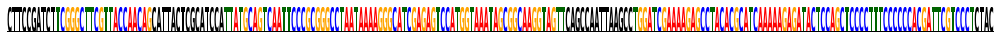

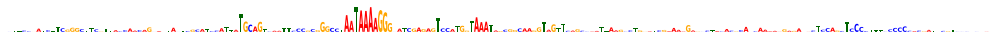

Test sequence 1:


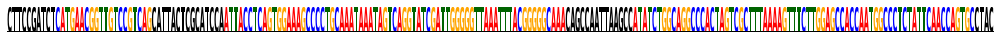

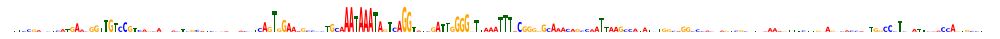

Test sequence 2:


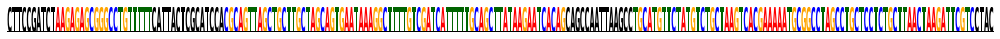

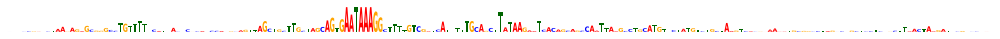

Test sequence 3:


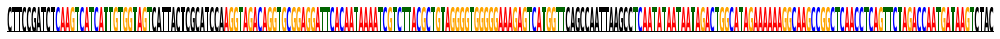

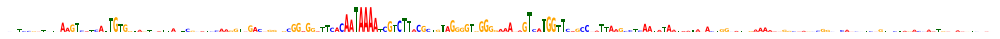

Test sequence 4:


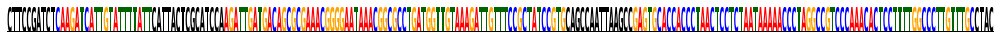

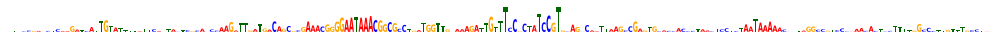

Attribution method = 'rescale'
Test sequence 0:


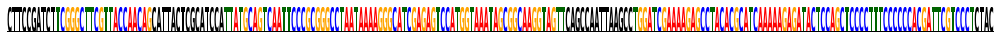

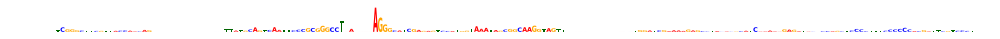

Test sequence 1:


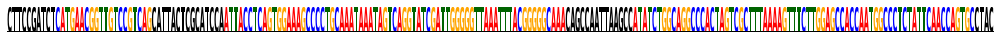

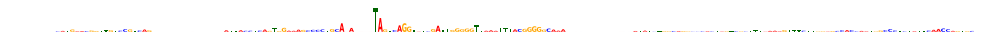

Test sequence 2:


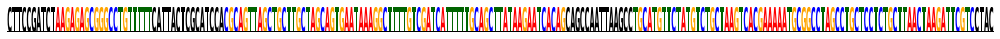

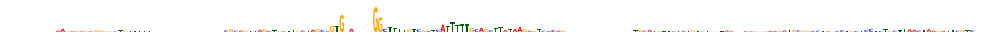

Test sequence 3:


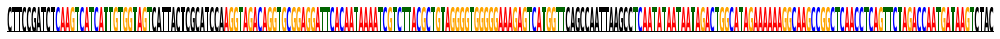

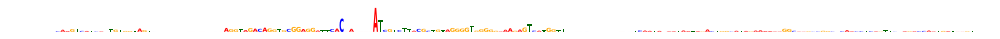

Test sequence 4:


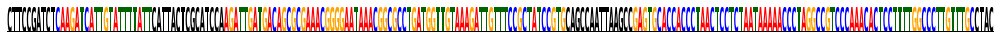

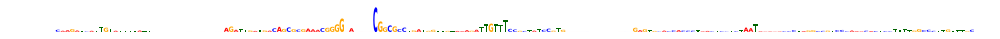

Attribution method = 'integrated_gradients'
Test sequence 0:


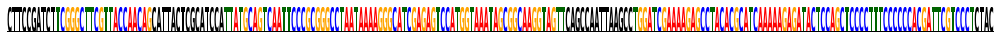

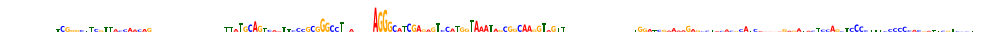

Test sequence 1:


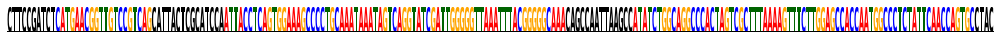

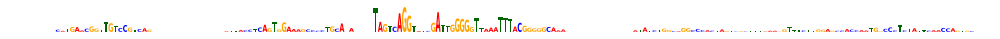

Test sequence 2:


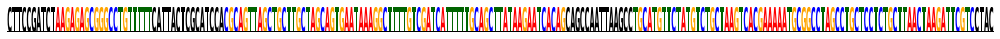

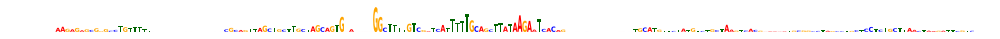

Test sequence 3:


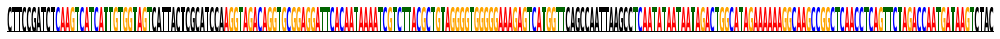

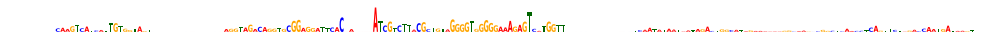

Test sequence 4:


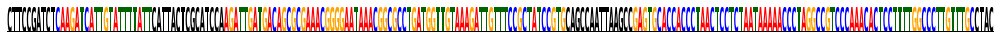

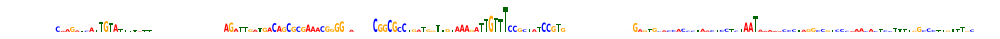

In [15]:
#Run attribution methods

encoder = isol.OneHotEncoder(205)

score_clip = 1.5

for attr_suffix, attr_method_name in zip(attribution_suffixes, attribution_method_names) :
    
    print("Attribution method = '" + attr_suffix + "'")

    importance_scores_test = _deep_explain(attr_method_name)#[0]
    importance_scores_test_signed = np.copy(importance_scores_test)
    importance_scores_test = np.abs(importance_scores_test)
    
    for plot_i in range(0, 5) :

        print("Test sequence " + str(plot_i) + ":")
        
        plot_dna_logo(x_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205)
        plot_importance_scores(importance_scores_test[plot_i, 0, :, :].T, encoder.decode(x_test[plot_i, 0, :, :]), figsize=(14, 0.65), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=205)

        #Save predicted importance scores

        model_name = "deepexplain_" + dataset_name + "_method_" + attr_suffix

        np.save(model_name + "_importance_scores_test", importance_scores_test)
        np.save(model_name + "_importance_scores_test_signed", importance_scores_test_signed)
